In [1]:
import pandas as pd
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
matplotlib.style.use('ggplot')

pd.options.display.float_format = '{:,.2f}'.format



In [2]:
# Load the file and filter where loan_status is current. 
#As we intend to use this for predicting bad loans, we use fully_paid and others that indicate defaulting
def load_file(f):
    df=pd.read_csv(f,header=0,skiprows=1,low_memory=False)
    df=df[df.loan_status!='Current']
    return df

In [3]:
# Load loan data files
path=r'C:\UniSyd\DataScience\LendingClub\LoanData'
all_files = glob.glob(os.path.join(path, "*.csv")) 
loan_data=pd.concat((load_file(f) for f in all_files), ignore_index=True)
print ("loaded loan data files")
print (loan_data.shape)

loaded loan data files
(589614, 111)


Remove Summary lines in each file. Also drop id and member_id columns that does not have any significant data in them .

In [4]:
loan_data.drop(loan_data[loan_data.id.str.contains('Total|Loans',na=False)==True].index,inplace=True)

loan_data.drop('id',axis=1,inplace=True)
loan_data.drop('member_id',axis=1,inplace=True)
print (loan_data.shape)

(589597, 109)


Convert the issue_d from string to a date type and extract the year from it as we are interested in year alone.

In [5]:
loan_data['issue_d']=pd.to_datetime(loan_data['issue_d'],format='%b-%Y')
loan_data['issue_d']=loan_data['issue_d'].dt.year

In [6]:
loan_data.issue_d.unique()

array([2011, 2010, 2009, 2008, 2007, 2013, 2012, 2014, 2015, 2016], dtype=int64)

In [7]:
loan_data[loan_data['issue_d'].isnull()]
loan_data[loan_data['issue_d']==0]
loan_data['issue_d'].dtype

dtype('int64')

In [8]:
loan_data['chargeoff_within_12_mths'].fillna(0,inplace=True)
loan_data.chargeoff_within_12_mths=loan_data['chargeoff_within_12_mths'].astype(int)

##### We are interested in finding the default status . Hence we use 1 for all status that indicate loan defaults and 0 for the fully paid status.

In [9]:
loan_data.loan_status.unique()
status_map={'Fully Paid':0, 'Charged Off':1, 'Late (31-120 days)':1,
       'Does not meet the credit policy. Status:Fully Paid':0,
       'Does not meet the credit policy. Status:Charged Off':1,
       'Late (16-30 days)':1, 'In Grace Period':1, 'Default':1}
loan_data['loan_status']=loan_data['loan_status'].map(lambda x: status_map[x])
loan_data.loan_status.unique()

array([0, 1], dtype=int64)

In [10]:
loan_data['prnc_charged_off']=(loan_data['loan_status'])*(loan_data['funded_amnt']-loan_data['total_pymnt'])
risky_by_year=loan_data[loan_data.loan_status==1][['issue_d','prnc_charged_off','funded_amnt','total_pymnt']].groupby('issue_d').agg({'prnc_charged_off':'sum','total_pymnt':'sum','funded_amnt':'count'})

risky_by_grade=loan_data[loan_data.loan_status==1][['issue_d','prnc_charged_off','funded_amnt','total_pymnt','grade']].groupby('grade').agg({'prnc_charged_off':'sum','total_pymnt':'sum','funded_amnt':'count'})


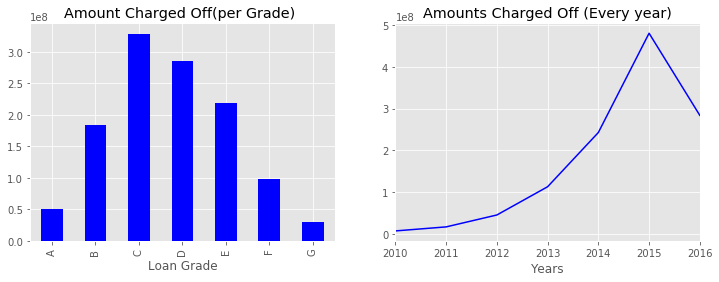

In [11]:
fig2,axs2=plt.subplots(ncols=2 ,figsize=(12, 4))
risky_by_grade['prnc_charged_off'].plot(kind='bar',title='Amount Charged Off(per Grade) ',ax=axs2[0],color='b')
axs2[0].set_xlabel('Loan Grade')
risky_by_year.loc[2010:2017]['prnc_charged_off'].plot(kind='line',title='Amounts Charged Off (Every year)',ax=axs2[1],color='b')
axs2[1].set_xlabel('Years')
fig2.savefig('ChargedOff.jpg')

,funded_amnt
loan_status,
0,0.7525
1,0.2475


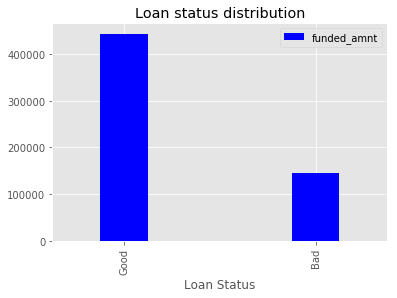

In [12]:
fig,axs=plt.subplots(ncols=1,figsize=(6, 4))
pd.options.display.float_format = '{:,.4f}'.format
loan_statuses=loan_data[['funded_amnt','loan_status']]\
                        .groupby('loan_status').agg({'funded_amnt':'count'})
loan_statuses.plot(kind='bar',ax=axs,color='b',title='Loan status distribution',width=0.25)
axs.set_xlabel('Loan Status')
axs.set_xticklabels(['Good','Bad'])
fig.savefig("LoanStatusDistribution.jpg")

loan_statuses/loan_data.shape[0]

In [13]:
loan_data['int_rate']=pd.Series(loan_data.int_rate).str.replace('%', '').astype(float)

In [14]:
loan_data['grade_enc']=loan_data.grade.map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
loan_data.sub_grade.unique()

sub_grade_map={'A1':35,'A2':34,'A3':33,'A4':32,'A5':31,
              'B1':30,'B2':29,'B3':28,'B4':27,'B5':26,
              'C1':25,'C2':24,'C3':23,'C4':23,'C5':21,
              'D1':20,'D2':19,'D3':18,'D4':17,'D5':16,
              'E1':15,'E2':14,'E3':13,'E4':12,'E5':11,
              'F1':10,'F2':9,'F3':8,'F4':7,'F5':6,
              'G1':5,'G2':4,'G3':3,'G4':2,'G5':1
              }
loan_data['sub_grad_enc']=loan_data.sub_grade.map(sub_grade_map)
loan_data['sub_grad_enc'].unique()

array([29, 23, 21, 25, 26, 32, 15,  9, 30, 20, 35, 28, 27, 24, 19, 33, 31,
       16, 34, 12, 18, 17,  8, 13,  7, 10, 11,  2, 14,  3,  4,  5,  6,  1], dtype=int64)

In [15]:
loan_data['emp_length']=loan_data['emp_length'].str.replace('year|\+|<|s| ','')
loan_data['emp_length']=loan_data['emp_length'].str.replace('n/a','0')
loan_data['emp_length']=loan_data.emp_length.astype(int)
loan_data.emp_length.unique()

array([10,  1,  3,  8,  9,  4,  5,  6,  2,  7,  0], dtype=int64)

In [16]:
loan_data[(loan_data.home_ownership=='NONE') & (loan_data.loan_status==0)]

from sklearn import preprocessing
lenc=preprocessing.LabelEncoder()

lenc.fit(loan_data.home_ownership.unique())
loan_data['home_own_enc']=lenc.transform(loan_data.home_ownership)
loan_data.home_own_enc;


In [17]:
loan_data['own_home']=(loan_data.home_ownership=='OWN').map({True:1,False:0})
loan_data['rent_home']=(loan_data.home_ownership=='RENT').map({True:1,False:0})
loan_data['mort_home']=(loan_data.home_ownership=='MORTGAGE').map({True:1,False:0})

In [18]:
lenc.fit(loan_data.addr_state.unique())
loan_data['state_enc']=lenc.transform(loan_data.addr_state)
loan_data.state_enc;

In [19]:
loan_data['term']=loan_data.term.map({' 36 months':36,' 60 months':60});

In [20]:
#for purpose in loan_data.purpose.unique():
#    print(purpose,loan_data[loan_data.purpose==purpose]['loan_status'].value_counts())
loan_data['verified']=(loan_data.verification_status!='Not Verified').map({True:1,False:0})



In [21]:
loan_data.shape
#labels=loan_data.loan_status.as_matrix()
#loan_data.drop('loan_status',inplace=True,axis=1)

loan_data.dtypes;
#loan_data[loan_data['acc_now_delinq']>0]['loan_status'].value_counts()
#loan_data[loan_data.avg_cur_bal.isnull()]['loan_status'].value_counts()
#loan_data[loan_data.delinq_2yrs>0]['loan_status'].value_counts()
#loan_data[(~loan_data.all_util.isnull()) & loan_data.loan_status==1]['all_util'].value_counts()
#loan_data.all_util.value_counts()
#loan_data.delinq_amnt.value_counts()
#loan_data[(loan_data.dti>30) & (loan_data.dti<40)]['loan_status'].value_counts()
#loan_data[(loan_data.inq_fi>0) & (loan_data.inq_fi <5)]['loan_status'].value_counts()
#loan_data[loan_data.num_accts_ever_120_pd>5]['loan_status'].value_counts()
loan_data.verification_status.unique()
loan_data[loan_data.verification_status!='Not Verified']['loan_status'].value_counts()


0    295222
1    112371
Name: loan_status, dtype: int64

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier



feature_array=['funded_amnt','acc_now_delinq','state_enc','annual_inc','chargeoff_within_12_mths'\
                   ,'delinq_2yrs','delinq_amnt','dti','emp_length','sub_grad_enc','inq_last_6mths','inq_last_12m'\
                   ,'issue_d','mort_acc','mths_since_last_delinq'
                   ,'mths_since_last_major_derog','num_accts_ever_120_pd','pct_tl_nvr_dlq','pub_rec_bankruptcies'\
                   ,'term','total_acc','own_home','rent_home','mort_home','installment','inq_fi','num_sats','avg_cur_bal'\
                   , 'all_util','verified']

for feature in feature_array:
    loan_data[feature]=loan_data[feature].fillna(0)

features=pd.concat([loan_data])[feature_array]
labels=pd.concat([loan_data])['loan_status']



scaler=StandardScaler()
features=scaler.fit_transform(features)
#clf=ExtraTreesClassifier(n_estimators=100)
#clf=LogisticRegression(class_weight={1:2,0:1},max_iter=300)
clf=AdaBoostClassifier(DecisionTreeClassifier()
                       ,algorithm='SAMME.R'
                       ,n_estimators=1000)

features_train,features_test,labels_train,labels_test=train_test_split(features,labels,test_size=0.25,random_state=42)

scores=cross_val_score(clf,features_train,labels_train,cv=5,scoring='f1')
print ('crossvalidation mean F1 :', np.mean(scores))

clf.fit(features_train,labels_train)
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,make_scorer
pred_labels=clf.predict(features_test)

f1_score(labels_test,pred_labels)



crossvalidation mean F1 : 0.35205151898


0.34833899207775781

In [76]:
precision_score(labels_test,pred_labels)

0.33759161763187778

In [22]:
from imblearn.over_sampling import  RandomOverSampler ,SMOTE
from imblearn.under_sampling import     RandomUnderSampler 
#from imblearn.ensemble import     BalanceCascade 


feature_array=['funded_amnt','acc_now_delinq','state_enc','annual_inc','chargeoff_within_12_mths'\
                   ,'delinq_2yrs','delinq_amnt','dti','emp_length','sub_grad_enc','inq_last_6mths','inq_last_12m'\
                   ,'issue_d','mort_acc','mths_since_last_delinq'
                   ,'mths_since_last_major_derog','num_accts_ever_120_pd','pct_tl_nvr_dlq','pub_rec_bankruptcies'\
                   ,'term','total_acc','own_home','rent_home','mort_home','installment','inq_fi','num_sats','avg_cur_bal'\
                   , 'all_util','verified']
#feature_array=['annual_inc','emp_length','dti','sub_grad_enc','mort_acc','all_util']
for feature in feature_array:
    loan_data[feature]=loan_data[feature].fillna(0)
    
#features=pd.concat([loan_data,loan_data[loan_data.loan_status==1],loan_data[loan_data.loan_status==1]])[feature_array]
#labels=pd.concat([loan_data,loan_data[loan_data.loan_status==1],loan_data[loan_data.loan_status==1]])['loan_status']
#features=pd.concat([loan_data,loan_data[loan_data.loan_status==1]])[feature_array]
#labels=pd.concat([loan_data,loan_data[loan_data.loan_status==1]])['loan_status']
features=pd.concat([loan_data])[feature_array]
labels=pd.concat([loan_data])['loan_status']
ros = RandomOverSampler(random_state=42)

features_res, labels_res = ros.fit_sample(features, labels)

labels_res.shape,features_res

((887302,), array([[  5.00000000e+03,   0.00000000e+00,   3.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
        [  2.40000000e+03,   0.00000000e+00,   1.40000000e+01, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  1.00000000e+04,   0.00000000e+00,   4.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
        ..., 
        [  1.93000000e+04,   0.00000000e+00,   4.20000000e+01, ...,
           1.91950000e+04,   0.00000000e+00,   1.00000000e+00],
        [  1.07500000e+04,   0.00000000e+00,   3.10000000e+01, ...,
           9.70000000e+02,   0.00000000e+00,   1.00000000e+00],
        [  1.82500000e+04,   0.00000000e+00,   4.00000000e+00, ...,
           3.09100000e+03,   0.00000000e+00,   1.00000000e+00]]))

In [23]:
np.unique(labels_res,return_counts=True)

(array([0, 1], dtype=int64), array([443651, 443651], dtype=int64))

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier



scaler=StandardScaler()
features=scaler.fit_transform(features)



clf=DecisionTreeClassifier(max_features='sqrt',class_weight={1:2,0:1})
#clf=LogisticRegression(C=0.01,class_weight={1:2,0:1},max_iter=300)
#clf=AdaBoostClassifier(ExtraTreesClassifier()
#                       ,algorithm='SAMME.R'
#                       ,n_estimators=200,
#                      )
#clf=AdaBoostClassifier(LogisticRegression(C=0.01,class_weight={1:2,0:1},solver='sag')
#                       ,algorithm='SAMME.R'
#                       ,n_estimators=1000)
#LogisticRegression()
#GaussianNB()
#DecisionTreeClassifier()
#clf=LinearSVC(C=0.001)
#clf=RandomForestClassifier(n_estimators=20,bootstrap=True)
#clf=ExtraTreesClassifier(n_estimators=100)
#clf=GradientBoostingClassifier()
#clf=SGDClassifier(n_iter=30,alpha=0.0001,n_jobs=4)

features_train,features_test,labels_train,labels_test=train_test_split(features_res,labels_res,test_size=0.25,random_state=42)

scores=cross_val_score(clf,features_train,labels_train,cv=5,scoring='f1')
scores


array([ 0.82720093,  0.82761685,  0.82824194,  0.82722666,  0.82735704])

In [80]:
clf.fit(features_train,labels_train)

DecisionTreeClassifier(class_weight={1: 2, 0: 1}, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [83]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,make_scorer
pred_labels=clf.predict(features_test)

precision_score(labels_test,pred_labels)
#pd.Series(pred_labels).value_counts()

0.79339961400352166

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 
from sklearn.ensemble import VotingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV

params = {'selection__k':[10,20,30],
                           'classifier__n_estimators': [100]
                           #'classifier__max_features': [0.8], 
                           #,'classifier__n_jobs': [-1]
                           #'classifier__min_samples_split': [10],
                           ,'pca__n_components': [2]
                           ,'pca__whiten': [True] 
                           }
pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                                        ('selection', SelectKBest(score_func=f_classif)), 
                                        ('pca', PCA()), 
                                        ('classifier', ExtraTreesClassifier()) 
                                        ]) 

sss_cv = StratifiedShuffleSplit(labels, test_size=0.1,random_state=42)
scoring_metric='f1'
grid_searcher = GridSearchCV(pipeline, param_grid=params,cv=5,
                                     scoring=scoring_metric, verbose=1) 
grid_searcher.fit(features_train, labels_train) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 30.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selection', SelectKBest(k=10, score_func=<function f_classif at 0x0000017800EB5AE8>)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('cl...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'selection__k': [10, 20, 30], 'classifier__n_estimators': [100], 'pca__n_components': [2], 'pca__whiten': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [28]:
pd.DataFrame(grid_searcher.cv_results_)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classifier__n_estimators,param_pca__n_components,param_pca__whiten,param_selection__k,params,rank_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,62.1402,10.5761,0.8207,0.9725,100,2,True,10,"{'classifier__n_estimators': 100, 'pca__n_comp...",2,...,0.8167,0.9668,0.8173,0.9668,0.8228,0.9763,2.3608,0.3597,0.0031,0.0047
1,71.8009,11.4306,0.7371,0.8566,100,2,True,20,"{'classifier__n_estimators': 100, 'pca__n_comp...",3,...,0.8201,0.9674,0.6447,0.7316,0.6710,0.7680,6.3584,0.5211,0.0681,0.0917
2,67.8786,10.9720,0.8403,0.9952,100,2,True,30,"{'classifier__n_estimators': 100, 'pca__n_comp...",1,...,0.8386,0.9943,0.8404,0.9932,0.8421,0.9984,0.9857,0.1875,0.0018,0.0025


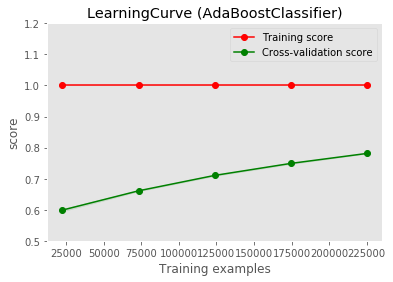

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit,ShuffleSplit,learning_curve
features_train_low,labels_train_low=resample(features_train,labels_train,n_samples=300000,random_state=42)


cv=StratifiedShuffleSplit(n_splits=10,test_size=0.25,random_state=42)
estimator=AdaBoostClassifier(DecisionTreeClassifier(max_features='sqrt',class_weight={1:2,0:1},criterion='gini')
                       ,algorithm='SAMME.R'
                       ,n_estimators=1000)

#estimator=ExtraTreesClassifier(n_estimators=10)
title='LearningCurve (AdaBoostClassifier)'
ylim=(0.5,1.2)
n_jobs=4
scorer=make_scorer(f1_score)
plt.figure()
plt.title(title)
plt.ylim(ylim)
plt.xlabel("Training examples")
plt.ylabel("score")
train_sizes=np.linspace(0.1,1.0,5)
train_sizes, train_scores, test_scores = learning_curve( \
        estimator, features_train_low, labels_train_low, cv=cv, \
        n_jobs=n_jobs, train_sizes=train_sizes, \
        scoring=scorer)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()


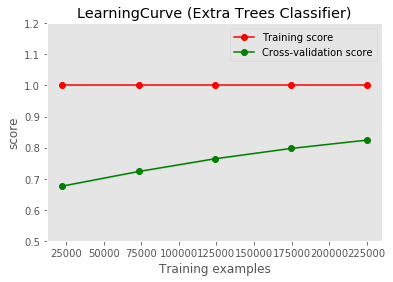

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit,ShuffleSplit,learning_curve
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,make_scorer

features_train,features_test,labels_train,labels_test=train_test_split(features_res,labels_res,test_size=0.25,random_state=42)
features_train_low,labels_train_low=resample(features_train,labels_train,n_samples=300000,random_state=42)
cv=StratifiedShuffleSplit(n_splits=5,test_size=0.25,random_state=42)

#estimator=AdaBoostClassifier(DecisionTreeClassifier(max_features='sqrt',class_weight={1:2,0:1},criterion='gini')
#                       ,algorithm='SAMME.R'
#                       ,n_estimators=1000)

estimator=ExtraTreesClassifier(n_estimators=100)
title='LearningCurve (Extra Trees Classifier)'
ylim=(0.5,1.2)
n_jobs=5
scorer=make_scorer(f1_score)
plt.figure()
plt.title(title)
plt.ylim(ylim)
plt.xlabel("Training examples")
plt.ylabel("score")
train_sizes=np.linspace(0.1,1.0,5)
train_sizes, train_scores, test_scores = learning_curve( \
        estimator, features_train_low, labels_train_low, cv=cv, \
         n_jobs=n_jobs,train_sizes=train_sizes, \
        scoring=scorer)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()


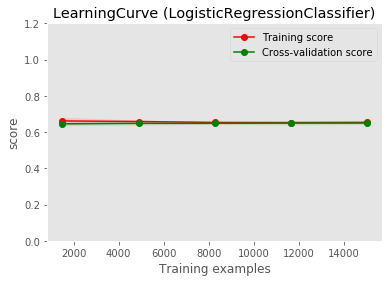

In [34]:
from sklearn.utils import resample
cv=StratifiedShuffleSplit(n_splits=5,test_size=0.25,random_state=42)
estimator=LogisticRegression(C=0.01,max_iter=4000,solver='lbfgs')
features_train_low,labels_train_low=resample(features_train,labels_train,n_samples=20000,random_state=42)
#estimator=ExtraTreesClassifier(n_estimators=20)
title='LearningCurve (LogisticRegressionClassifier)'
ylim=(0,1.2)
n_jobs=4
scorer=make_scorer(f1_score)
plt.figure()
plt.title(title)
plt.ylim(ylim)
plt.xlabel("Training examples")
plt.ylabel("score")
train_sizes=np.linspace(0.1,1.0,5)
train_sizes, train_scores, test_scores = learning_curve( \
        estimator, features_train_low, labels_train_low, cv=cv, \
         n_jobs=n_jobs,train_sizes=train_sizes, \
        scoring=scorer)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()


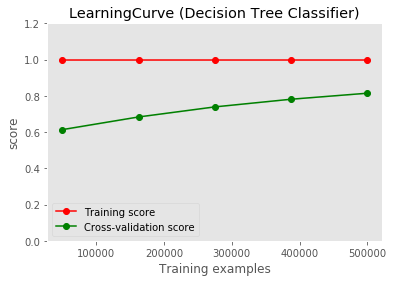

In [35]:
from sklearn.utils import resample
cv=StratifiedShuffleSplit(n_splits=5,test_size=0.25,random_state=42)
estimator=DecisionTreeClassifier()
features_train_low,labels_train_low=resample(features_train,labels_train,n_samples=300000,random_state=42)
#estimator=ExtraTreesClassifier(n_estimators=20)
title='LearningCurve (Decision Tree Classifier)'
ylim=(0,1.2)
n_jobs=4
scorer=make_scorer(f1_score)
plt.figure()
plt.title(title)
plt.ylim(ylim)
plt.xlabel("Training examples")
plt.ylabel("score")
train_sizes=np.linspace(0.1,1.0,5)
train_sizes, train_scores, test_scores = learning_curve( \
        estimator, features_train, labels_train, cv=cv, \
         n_jobs=n_jobs,train_sizes=train_sizes, \
        scoring=scorer)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()


In [36]:
estimator.fit(features_train,labels_train)
pred_labels=estimator.predict(features_test)

f1_score(labels_test,pred_labels)


0.85219527071021761

In [59]:
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 
from sklearn.model_selection import GridSearchCV

x=randint.rvs(1,30,size=10)

params = {"classifier__max_depth": [3, None],
              "classifier__max_features": x,
              "classifier__min_samples_leaf": x,
              "classifier__criterion": ["gini", "entropy"]
         }

pipeline = Pipeline(steps=[('classifier', DecisionTreeClassifier()) 
                                        ]) 

sss_cv = StratifiedShuffleSplit(labels, test_size=0.1,random_state=42)
scoring_metric='f1'
grid_searcher = GridSearchCV(pipeline, param_grid=params,cv=5,
                                     scoring=scoring_metric, verbose=1
                            ,n_jobs=4) 
grid_searcher.fit(features_train, labels_train) 


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 21.4min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 36.9min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 56.3min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed: 69.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('classifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'classifier__max_depth': [3, None], 'classifier__max_features': array([27,  6,  8,  3, 20, 14, 19, 26,  5, 20]), 'classifier__min_samples_leaf': array([27,  6,  8,  3, 20, 14, 19, 26,  5, 20]), 'classifier__criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [60]:
df=pd.DataFrame(grid_searcher.cv_results_)
df[df['rank_test_score']==1]['params'].values

array([ {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': 27, 'classifier__min_samples_leaf': 3}], dtype=object)

In [78]:
df[df['rank_test_score']==1]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_leaf,params,rank_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
303,24.3680,0.1809,0.7843,0.9573,entropy,None,27,3,"{'classifier__criterion': 'entropy', 'classifi...",1,...,0.7862,0.9575,0.7852,0.9572,0.7836,0.9573,0.1471,0.0132,0.0013,0.0003
